In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
TRAIN_IMAGES =  './dataset/csvTrainImages 60k x 784.csv'
TRAIN_LABELS = './dataset/csvTrainLabel 60k x 1.csv'
TEST_IMAGES = './dataset/csvTestImages 10k x 784.csv'
TEST_LABELS = './dataset/csvTestLabel 10k x 1.csv'

In [29]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, images_file, labels_file):
        self.images = pd.read_csv(images_file, header=None).values.reshape(-1, 28, 28).astype(np.float32) / 255
        self.labels = pd.read_csv(labels_file, header=None).values.astype(np.compat.long)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index][0]
        return image, label


In [30]:
train_dataset = ImageDataset(TRAIN_IMAGES, TRAIN_LABELS)
test_dataset = ImageDataset(TEST_IMAGES, TEST_LABELS)

In [31]:
print(f"Train Dataset Length: {len(train_dataset)}, Test Dataset Length: {len(test_dataset)}")

Train Dataset Length: 60000, Test Dataset Length: 10000


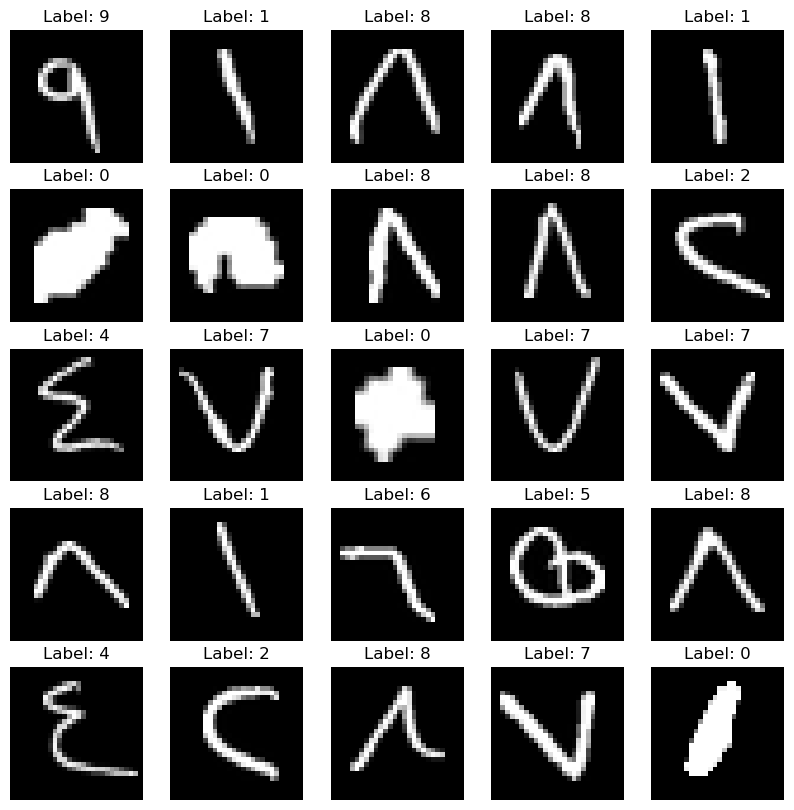

In [32]:
# Choose a number of random samples to display
num_samples = 25

# Randomly select the samples to display
indices = np.random.choice(len(train_dataset), size=num_samples, replace=False)

# Get the images and labels for the selected samples
images, labels = zip(*[train_dataset[i] for i in indices])
images = [torch.from_numpy(img) for img in images]
images = torch.stack(images).permute(0, 2, 1)
labels = np.stack(labels)

# Plot the images in a grid
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(images[i * 5 + j].numpy(), cmap="gray")
        ax[i, j].set_title(f"Label: {labels[i * 5 + j]}")
        ax[i, j].axis("off")
plt.show()


In [46]:
# Define device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
elif torch.backends.mps.is_available():
    device = "mps"

print(device)

mps


In [34]:
# Define the network
class FirstNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the network and transfer it to the device
model_1 = FirstNetwork().to(device)

In [35]:
# Define the network
class SecondNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28 * 28, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Instantiate the network and transfer it to the device
model_2 = SecondNetwork().to(device)

In [36]:
# Define the network
class ThirdNetwork(nn.Module):
    def __init__(self):
        super(ThirdNetwork, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Batch normalization to stabilize and speed up training
        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)
        
        # Dropout to prevent overfitting
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

# Instantiate the network and transfer it to the device
model_3 = ThirdNetwork().to(device)

In [37]:
def train(model, dataset, epochs, batch_size, optimizer):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()  # Define the loss function
    correct = 0
    total = 0
    
    for epoch in range(epochs):
        running_loss = 0.0  # Accumulate the running loss to calculate the average loss per epoch
        for i, (images, labels) in enumerate(dataloader, 0):
            images, labels = images.to(device), labels.to(device)  # Transfer the data to the device
            optimizer.zero_grad()  # Reset the gradients from previous training iterations
            outputs = model(images)  # Forward pass through the model
            _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
            total += labels.size(0)  # Accumulate the number of images
            correct += (predicted == labels).sum().item()  # Accumulate the number of correct predictions
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Compute the gradients for backpropagation
            optimizer.step()  # Perform a gradient update on the model's parameters
            running_loss += loss.item()  # Accumulate the running loss
        
        accuracy = 100 * correct / total  # Calculate the accuracy per epoch
        print(f"Epoch [{epoch+1}][{epochs}], Loss: {running_loss / (i + 1):.2f}, Accuracy: {accuracy:.2f}")
    print('Finished Training')


In [38]:
print('Training The First Network...')

train(model_1, train_dataset, 10, 16, torch.optim.SGD(model_1.parameters(), lr=1e-3))

Training The First Network...
Epoch [1][10], Loss: 2.21, Accuracy: 16.70
Epoch [2][10], Loss: 1.87, Accuracy: 30.40
Epoch [3][10], Loss: 1.20, Accuracy: 46.37
Epoch [4][10], Loss: 0.59, Accuracy: 57.01
Epoch [5][10], Loss: 0.38, Accuracy: 63.97
Epoch [6][10], Loss: 0.30, Accuracy: 68.81
Epoch [7][10], Loss: 0.25, Accuracy: 72.36
Epoch [8][10], Loss: 0.23, Accuracy: 75.08
Epoch [9][10], Loss: 0.21, Accuracy: 77.24
Epoch [10][10], Loss: 0.20, Accuracy: 79.00
Finished Training


In [39]:
print('Training The Second Network...')

train(model_2, train_dataset, 8, 32, torch.optim.Adam(model_2.parameters()))

Training The Second Network...
Epoch [1][8], Loss: 0.24, Accuracy: 93.17
Epoch [2][8], Loss: 0.09, Accuracy: 95.36
Epoch [3][8], Loss: 0.06, Accuracy: 96.31
Epoch [4][8], Loss: 0.05, Accuracy: 96.87
Epoch [5][8], Loss: 0.04, Accuracy: 97.27
Epoch [6][8], Loss: 0.03, Accuracy: 97.55
Epoch [7][8], Loss: 0.03, Accuracy: 97.77
Epoch [8][8], Loss: 0.03, Accuracy: 97.96
Finished Training


In [40]:
print('Training The Third Network...')

train(model_3, train_dataset, 10, 32, torch.optim.Adam(model_3.parameters()))

Training The Third Network...
Epoch [1][10], Loss: 0.19, Accuracy: 95.39
Epoch [2][10], Loss: 0.08, Accuracy: 96.56
Epoch [3][10], Loss: 0.06, Accuracy: 97.07
Epoch [4][10], Loss: 0.05, Accuracy: 97.40
Epoch [5][10], Loss: 0.05, Accuracy: 97.63
Epoch [6][10], Loss: 0.04, Accuracy: 97.81
Epoch [7][10], Loss: 0.04, Accuracy: 97.95
Epoch [8][10], Loss: 0.03, Accuracy: 98.07
Epoch [9][10], Loss: 0.03, Accuracy: 98.18
Epoch [10][10], Loss: 0.03, Accuracy: 98.26
Finished Training


In [41]:
def test(model, dataset, batch_size, n_missclassified):
    model.eval() # Set the model to evaluation mode
    correct = 0
    total = 0
    misclassified_images = [] # To keep track of misclassified images
    
    with torch.no_grad(): # Turn off gradients for evaluation
        for data in torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False):
            images, labels = data
            images, labels = images.to(device), labels.to(device) # Transfer data to device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
            # Keep track of misclassified images
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    misclassified_images.append((images[i], predicted[i].item(), labels[i].item()))
    
    accuracy = 100 * correct / total
    print(f"Accuracy of the network on the test images: {accuracy:.2f}\n")
    
    # Display the misclassified images
    if len(misclassified_images) > 0:
        print(f"{n_missclassified} of Misclassified Images:")
        fig, axes = plt.subplots(5, 5, figsize=(15, 15))
        for i, (img, pred, true) in enumerate(misclassified_images[:n_missclassified]):
            ax = axes.ravel()[i]
            ax.imshow(img.cpu().reshape(28, 28).permute(1, 0), cmap='gray')
            ax.set_title("True: {}\nPred: {}".format(true, pred))
            ax.axis('off')
        plt.subplots_adjust(wspace=1, hspace=1)
        plt.show()

Testing The First Model
Accuracy of the network on the test images: 93.53

25 of Misclassified Images:


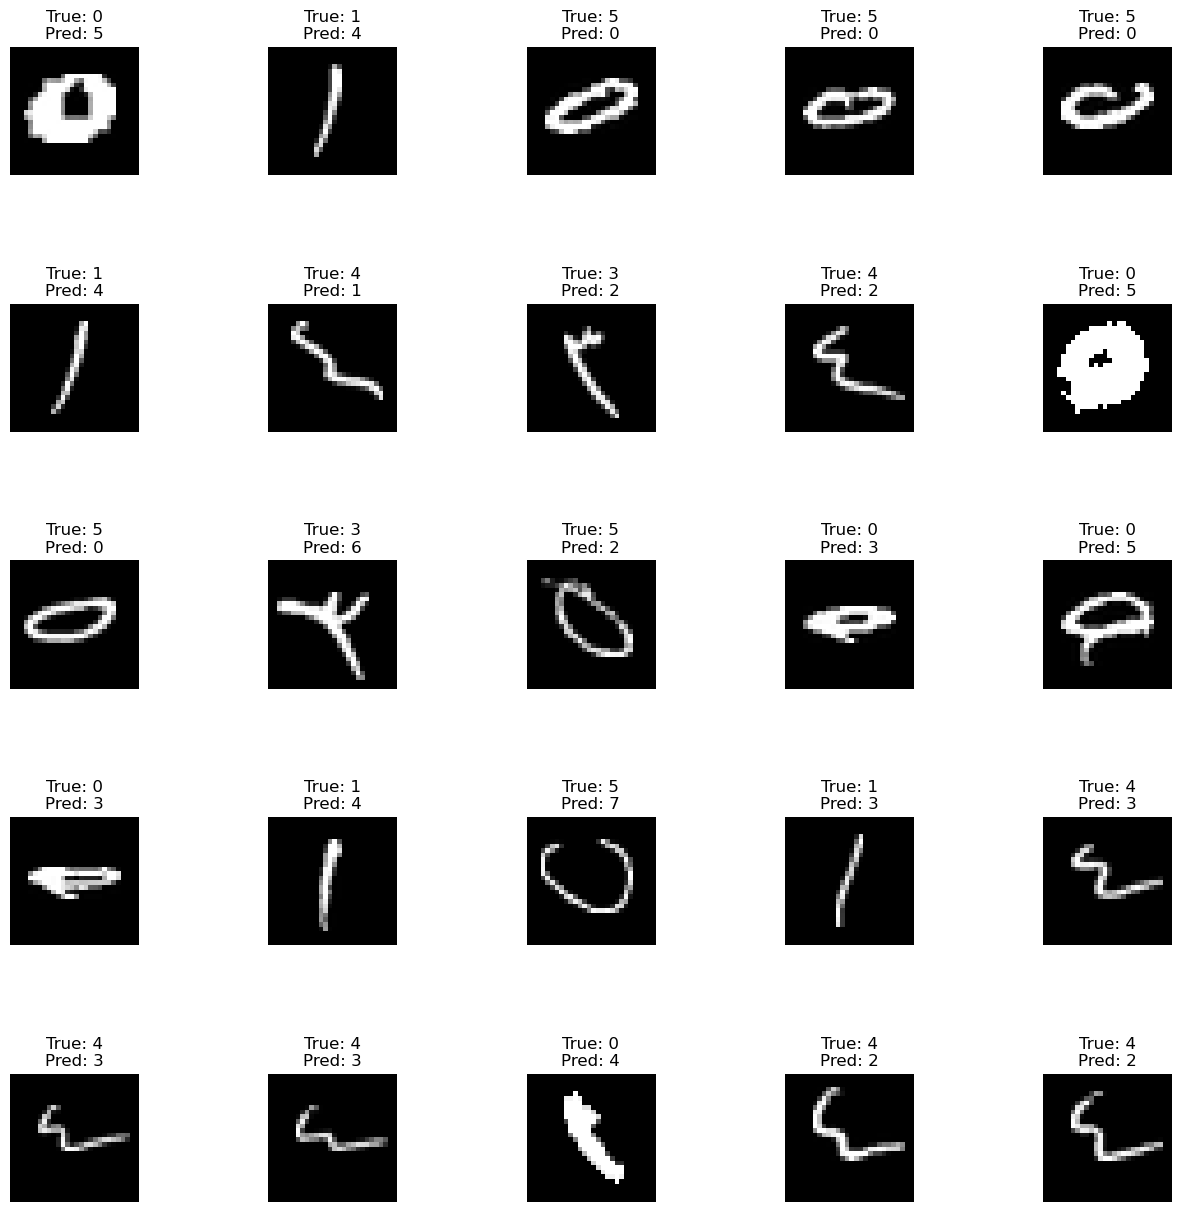

In [42]:
print('Testing The First Model')

test(model_1, test_dataset, 32, 25)

Testing The Second Model
Accuracy of the network on the test images: 97.76

25 of Misclassified Images:


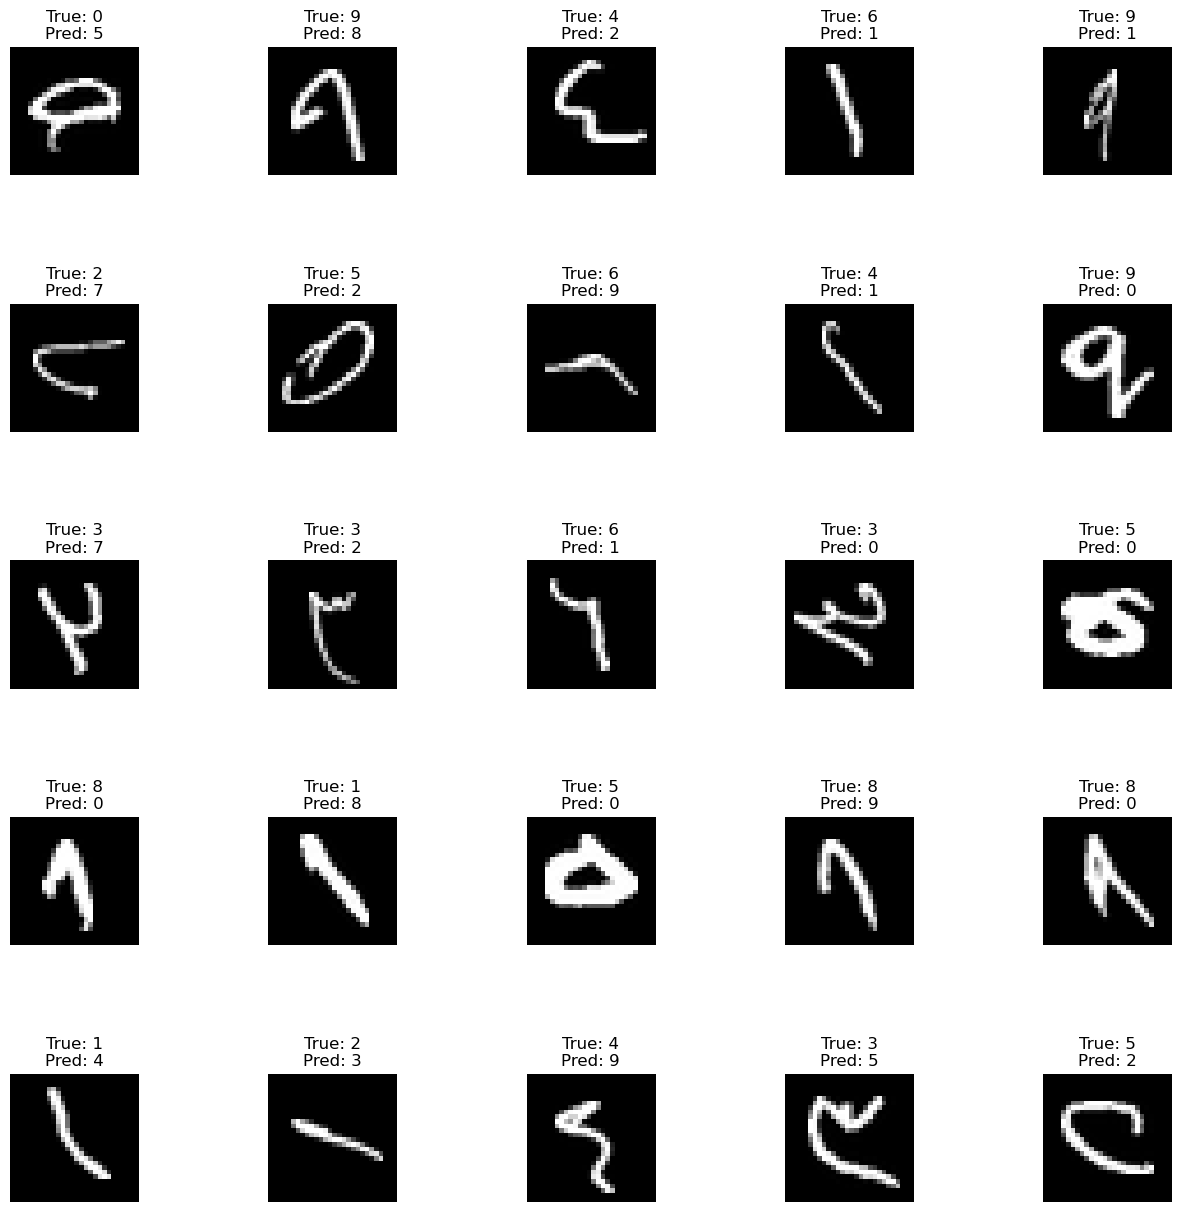

In [43]:
print('Testing The Second Model')

test(model_2, test_dataset, 32, 25)

Testing The Third Model
Accuracy of the network on the test images: 98.59

25 of Misclassified Images:


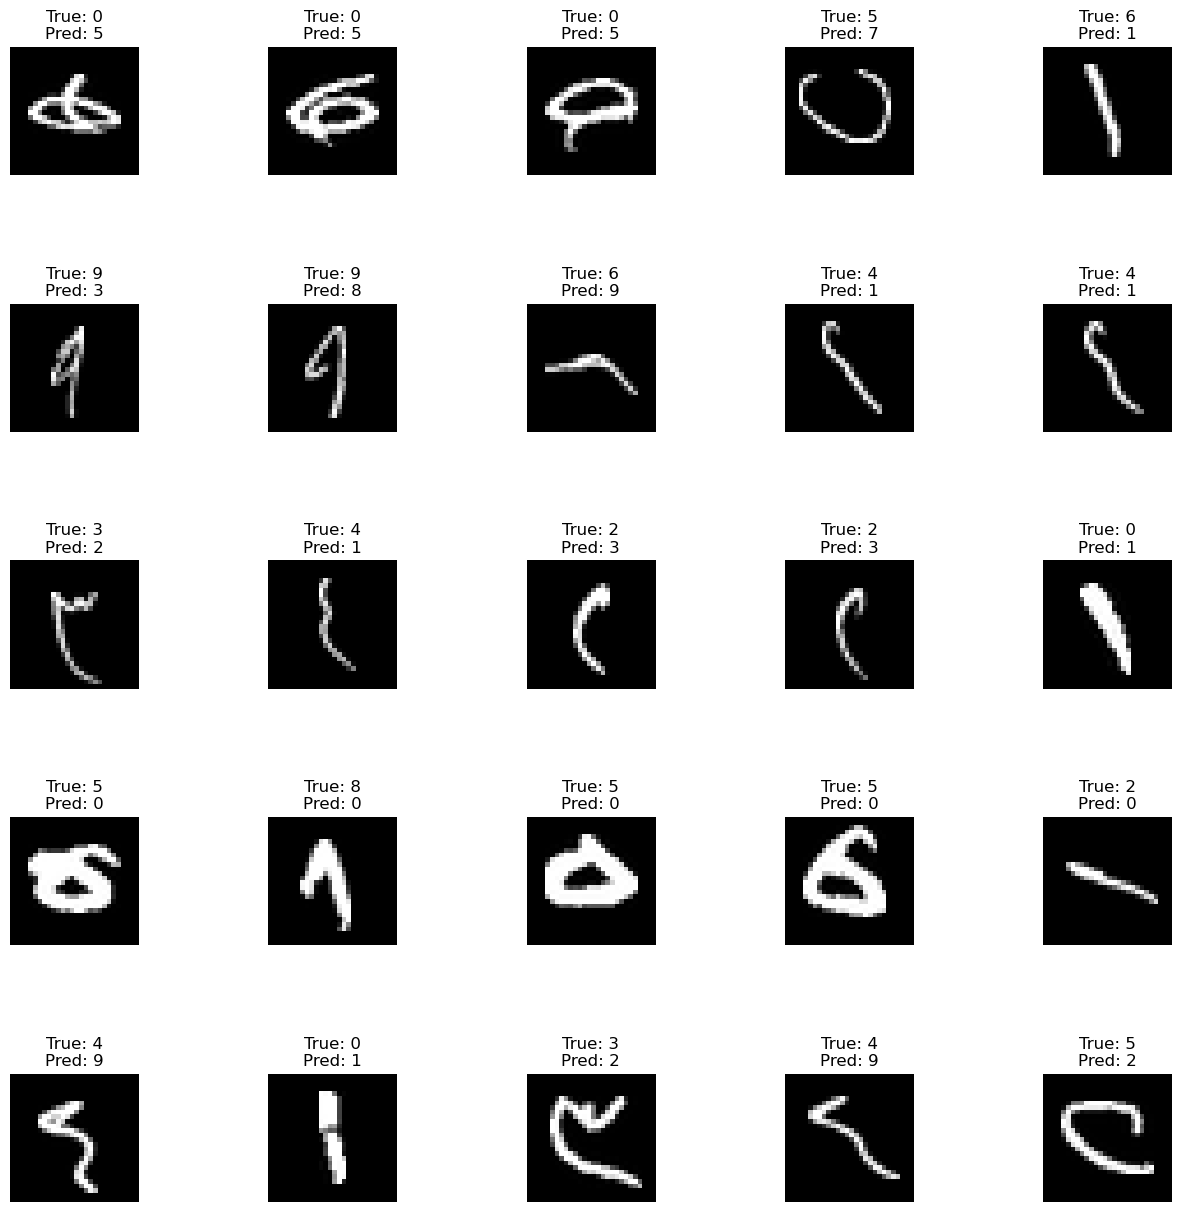

In [44]:
print('Testing The Third Model')

test(model_3, test_dataset, 32, 25)